### <p style="color:blue;"> Table of Contents </p>

1. Introduction
 
2. Research Question
 
3. Data Requirements

4. Data Collection

5. Data Preparation
  
6. Brief EDA
     
7. Data Transformation
 
8. Model selection

9. Clustering
         
10. Modelling: Prophet model
    - 10.1 Modeling Prophet with cluster
    - 10.2 Validation
    - 10.3 Optimization
    
11. Modelling: LSTM model
    - 11.1 Modeling LSTM with cluster
    - 11.2 Validation   
    - 11.3 Optimization 
 

12. Model comparison


13. Final result explanation



# 1. Introduction

The project is mainly focused on the use of airtificial intelligence in order to improve stock management for a well known pharmaceutical company known as informa.

We will be able to help informa to improve there stock management by providing insights with in the data and making predictions of sales for products by pharmacies because then we will be able to know which products will be sold by  pharmacies over time and for that matter it will be easier to determine how much you should have in stock.


# 2. Research question

#### <p style="color:blue;">**question:** To what extent can stock improvement be done through the use of data and artificial intelligence? </p>

We will try to find out the sales of products by pharmacies over time and with that we will make predictions for the future period and that will enable us to know the stock required.

#### <p style="color:blue;">**Sub-question 1:** How can we secure the amount of stock for each product so the store always have enough product in stock to supply? How can we predict sale for huge range of products? </p>

We will try to forcast the sale for each product or group of product with high accuracy score so the pharmacy can restock enough product to sell to prevent the pharmacy from being overstock and understock.

#### <p style="color:blue;">**Sub-question 2:** How can we taking into account inventory stocking and possible financial loss for short-life product? </p>

To prevent loss from stocking too much product that have short expiry date. We consider comparing the predicted sale with monthly min, max and average sale. We group product into product with short expiry date with high stock value and short expiry product with low stock value. For product with high stock value, we can consider only stock the amount that range between minimum and average sale by month.

# 3. Data requirements

### <p style="color:blue;"> In the data we would like to have one dataset with the following columns: </p>

- PatientToken: To identify specific patients
- SupplyDate: To perform time-dependent analysis by date
- SupplyTime: To perform time-dependent analysis on the crowds at a pharmacy
- Pharmacy: To specify pharmacies
- YOB: To make target audience predictions for age
- Gender: To make target audience predictions for gender
- CNK: To specify the identification of the product
- ProductName: To read the name of the product
- ATCcode: To specifies on which organ or system the product works on, and how it works
- Units: To know the amount of units there are in a packaged
- Price: The price of the product
- PatientAge:To make target audience predictions for age
- AgeSegment:To make target audience predictions for age
- Linetotal:
- Weekday: To perform time-dependent analysis by weekday
- Month: To perform time-dependent analysis by month
- Year: To perform time-dependent analysis by year
- Season: To perform time-dependent analysis by season
- AtcLetter: To specifies on which organ or system the product works on
- ATCclassification: Explanation what the ATC letters mean

## 4. DATA COLLECTION

The primary focus is to improve stock management and for that case we will predict the sales over time,therefore the data that is needed to be collected to make the predictions possible. 
The data that we received from informa included supply date,pharmacy,product name,units, price and more all concerning the daily patient purchase of products in pharmacies. The reason for collecting data like units would help us to know which units where purchased and for things like date is quite important to know when it was purchased to be able to know the sales overtime.


# 5. Data preparation

### <p style="color:blue;"> Preparing the data that we collected in order to be able to get insights out of it. </p>


#### Importing the required libraries

In [373]:
import pandas as pd
from pandas import to_datetime
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from datetime import datetime
from pandas.api.types import CategoricalDtype
from calendar import day_name
import matplotlib.ticker as mtick
import math 
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

#### Importing the dataset and remove uneccesary columns

In [374]:
pharmacy_ds = pd.read_csv(r'C:\Users\minhh\OneDrive\Desktop\ML\Project\pharmacy_cleaned.csv', parse_dates=True)
pharmacy_ds['SupplyDate']= pd.to_datetime(pharmacy_ds['SupplyDate'], infer_datetime_format=True) #date to datetime
pharmacy_sale = pharmacy_ds.drop(['Unnamed: 0','PatientToken', 'SupplyTime', 'YOB', 'Gender','Weekday', 'PatientAge', 'AgeSegment','ATCletter','ATCclassification','Month','Year','Season','CNK','ATCcode'],axis=1)
pharmacy_sale

,SupplyDate,Pharmacy,ProductName,Units,Price
0,2014-01-01,A1,"SYMBICORT TURBOHALER 160MCG/4,5MCG DOSES 1X120",1,61.86
1,2014-01-01,A1,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,30.18
2,2014-01-01,A1,TRADONAL RETARD CAPS 60 X 150 MG,60,31.88
3,2014-01-01,A4,FELDENE LYOTABS 30X20MG,30,16.83
4,2014-01-01,A1,COVERAM 5MG/10MG COMP 90,90,66.90
...,...,...,...,...,...
1111822,2020-12-31,A6,CYCLOCUR DRAG 3X21,21,9.17
1111823,2020-12-31,A3,PANTOMED 40 MG TABL 28,28,12.87
1111824,2020-12-31,A6,AMOXICILLINE SANDOZ 500MG/5ML PDR ORALE SUSP 1...,1,8.14
1111825,2020-12-31,A5,COLOFIBER SACH. GRAN. 20 X 7 GR,20,13.57


# 6. Brief EDA

### <p style="color:blue;"> In this section we will do some eda to get a more understanding of what is happening in our data. </p>


### Total number of unique products that we have in our dataset

#### <p style="color:green;"> We see that we have a total of 5760 unique products in our dataset which is quite alot but we couldn't expect less for pharmaceautic products. </p>

In [375]:
# How many unique product do we have ?
pharmacy_sale[["ProductName"]].nunique()

ProductName    5760
dtype: int64

### What does the units column represent

#### <p style="color:green;"> We can see that the units column in our pharmacy dataset represent the number of items that are in a package. So we can say in this circumstance, this variable does not account for the sale. </p>


In [376]:
pharmacy_sale[pharmacy_sale['ProductName']=='PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56']

,SupplyDate,Pharmacy,ProductName,Units,Price
1,2014-01-01,A1,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,30.18
366,2014-01-02,A1,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,30.18
557,2014-01-03,A1,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,30.18
1418,2014-01-06,A1,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,30.18
2630,2014-01-08,A1,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,31.47
...,...,...,...,...,...
1106441,2020-12-16,A2,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,20.55
1106671,2020-12-16,A3,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,20.55
1110675,2020-12-28,A2,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,20.55
1111212,2020-12-30,A2,PANTOPRAZOLE EG 40MG MAAGSAPRESIST.TABL BLIST 56,56,20.55


### Are there different types of medicine for a productname?

#### <p style="color:green;"> As we can see, a product can be in different kind such as compact, tablets or liquid. </p>


In [377]:
pharmacy_sale['ProductName'][pharmacy_sale['ProductName'].str.contains("ZYRTEC")].unique()

array(['ZYRTEC DRINKB OPL 200ML 1MG/ML',
       'ZYRTEC 10 MG FILMOMH TABL 40 X 10 MG',
       'ZYRTEC 10 MG FILMOMH TABL 20 X 10 MG',
       'ZYRTEC GUTT 20 ML X 10 MG/ML',
       'ZYRTEC IMPEXECO COMP PELL 40 X  10MG PIP',
       'ZYRTEC IMPEXECO COMP PELL 20 X  10MG PIP'], dtype=object)

### Are the units and price unique for each product?

**Findings:**
#### <p style="color:green;">The unit for each product seems to not change over time (right plot). However, the price for the same product is not unique, and it is understandable because the price for a product can be increased over time. </p>
**Solution:** 
#### <p style="color:green;">To make prediction from historical data for future stocking purpose, it is best to set the latest price for each product (which is the highest price). </p>

<AxesSubplot:xlabel='Units', ylabel='Count'>

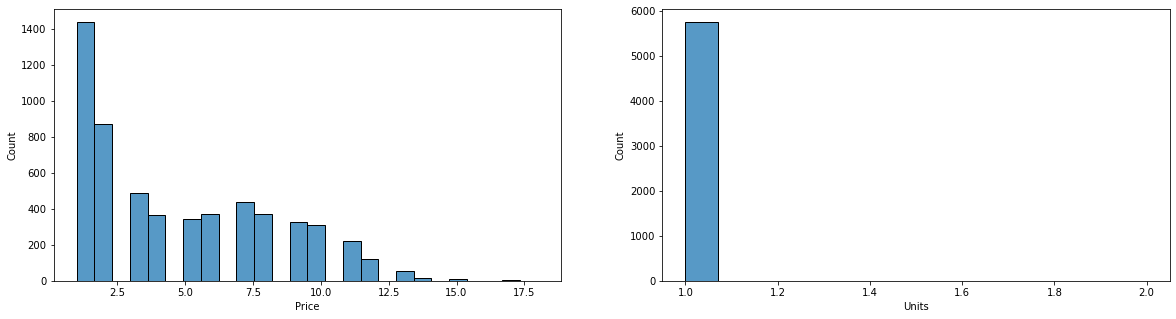

In [378]:
unique = pharmacy_sale.groupby(["ProductName"])["Units",'Price'].nunique().reset_index()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
sns.histplot(data=unique, x="Price",ax=ax[0])
sns.histplot(data=unique, x="Units",ax=ax[1])

**Transformation:**
### <p style="color:blue;"> Replace the price for each product with latest price. </p>


In [379]:
#First, make a dataframe with unique product and max price of that product
prod_maxPrice = pharmacy_sale.groupby(["ProductName",'Units'])['Price'].max().reset_index()
prod_maxPrice
#Merge that df to original df
pharmacy_sale = pharmacy_sale.merge(prod_maxPrice, how='inner', on=('ProductName','Units'), suffixes=('_y', '')).drop('Price_y',axis=1)
pharmacy_sale

,SupplyDate,Pharmacy,ProductName,Units,Price
0,2014-01-01,A1,"SYMBICORT TURBOHALER 160MCG/4,5MCG DOSES 1X120",1,61.86
1,2014-01-02,A1,"SYMBICORT TURBOHALER 160MCG/4,5MCG DOSES 1X120",1,61.86
2,2014-01-02,A2,"SYMBICORT TURBOHALER 160MCG/4,5MCG DOSES 1X120",1,61.86
3,2014-01-02,A2,"SYMBICORT TURBOHALER 160MCG/4,5MCG DOSES 1X120",1,61.86
4,2014-01-03,A2,"SYMBICORT TURBOHALER 160MCG/4,5MCG DOSES 1X120",1,61.86
...,...,...,...,...,...
1111822,2020-12-28,A2,QUETIAPINE KRKA 100MG FILMOMH TABL 60,60,31.69
1111823,2020-12-29,A1,QUETIAPINE KRKA 100MG FILMOMH TABL 60,60,31.69
1111824,2020-12-30,A6,CIMZIA 200MG OPL INJ 2 VOORGEV.PENNEN + 2 TAMPONS,2,1009.02
1111825,2020-12-30,A3,QUETIAPINE KRKA 200MG FILMOMH TABL 30,30,17.81


# 7. Data Transformation

### <p style="color:blue;"> In this section we will transform our data in a way that it is able to do what we expect it to do </p>


### First we will get daily sales
#### <p style="color:green;">In that case we will create a new column Sale to calculate sold amount of a product in a day </p>


In [380]:
pharmacy_sale = pharmacy_sale.groupby(['SupplyDate', 'Pharmacy', "ProductName",'Units','Price']).agg(Sale= ('ProductName','count')).reset_index()
pharmacy_sale

,SupplyDate,Pharmacy,ProductName,Units,Price,Sale
0,2014-01-01,A1,"ATROVENT MONODOSE 0,25MG/2ML VIALS 20",20,11.85,1
1,2014-01-01,A1,COVERAM 5MG/10MG COMP 90,90,66.90,1
2,2014-01-01,A1,"ELTHYRONE COMP 100 X 0,050MG",100,6.39,1
3,2014-01-01,A1,"GASVORM ZUURST AIR B10 2,10M3B200",1,12.15,1
4,2014-01-01,A1,"GASVORM ZUURST AIR B20 4,20M3B200",1,24.31,1
...,...,...,...,...,...,...
772633,2020-12-31,A6,VENTOLIN AERO INHAL 200DOS 100MCG/D,1,8.26,2
772634,2020-12-31,A6,WELLBUTRIN XR 150 MG TABS 90 X 150 MG,90,74.39,1
772635,2020-12-31,A6,"XALATAN 0,005 % COLLYRE 3X2,5 ML",3,62.28,1
772636,2020-12-31,A6,"ZALDIAR 37,5 MG/325 MG FILMOMH TABL 100 BLISTER",100,17.10,1


#### <p style="color:green;">The data below shows all the unique pharmacies that we have in our informa dataset </p>


In [381]:
pharmacy_sale['Pharmacy'].unique()

array(['A1', 'A4', 'A2', 'A3', 'A5', 'A6'], dtype=object)

### A graph showing sales across years for all pharmacies

#### <p style="color:green;">In the year 2016 and 2017 we see a spike in sales. Next, we narrow it down to each pharmacy to see what cause a spike in 2016 </p>

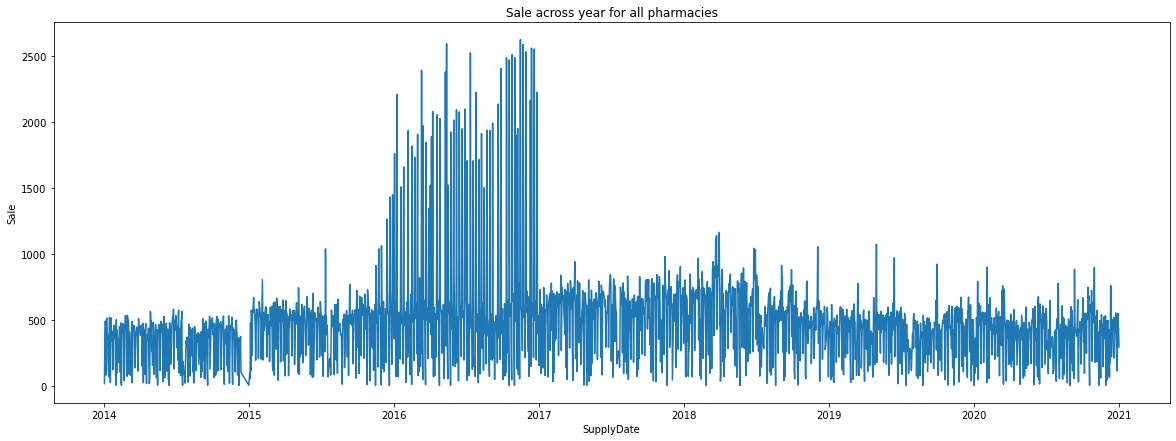

In [382]:
sale_year = pharmacy_sale.groupby("SupplyDate").agg(Sale= ('Sale','sum'))
sale_year.sort_index(inplace=True)
plt.figure(figsize=(20,7))
sns.lineplot(data=sale_year, x="SupplyDate", y="Sale")
plt.title('Sale across year for all pharmacies')
plt.show()

### A graph showing sales across years for each pharmacy

<p style="color:green;"> * Pharmacy A4 have unstable data, which caused the abnomality in the sale through the years. Also, the data for A4 only available until 2019, so it can be considered closed, so we can consider remove this pharmacy for modelling to avoid outliers </p> 
<p style="color:green;"> * Pharmacy A6 does not have data for 2014. However, the goal of this notebook is to predict the stock for all pharmacy so we can leave this aside. </p> 
<p style="color:green;"> * There are big gaps in the end of 2014 for all pharmacy and some small gaps across the year. We can try replace it with previous or next value. However, as Prophet is a model that can handle missing values and outliers, we can also leave this aside. If the accuracy score is not good enough, we can try to replace this manually. </p>

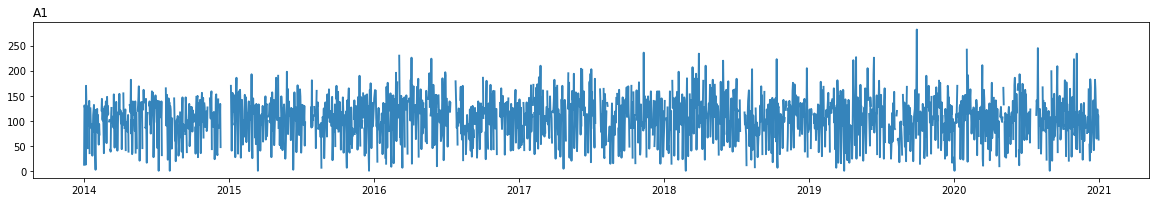

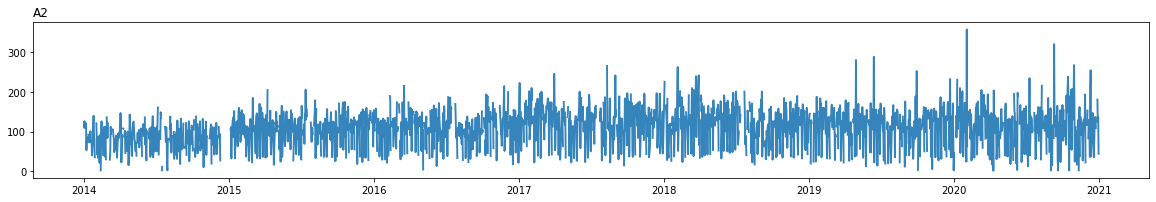

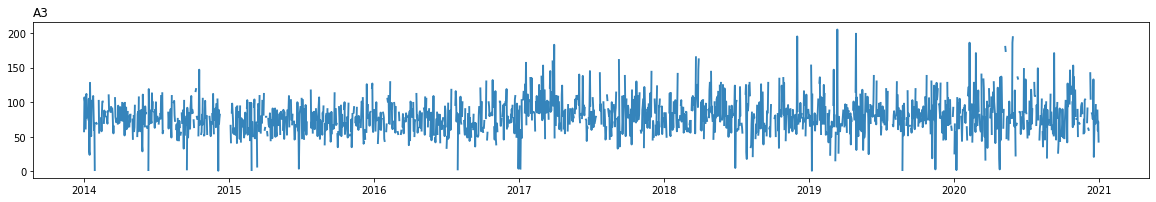

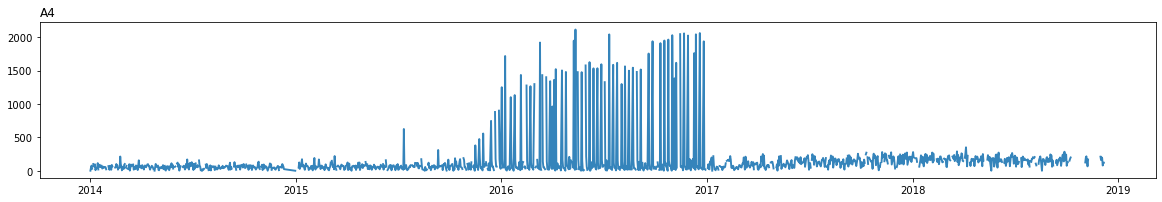

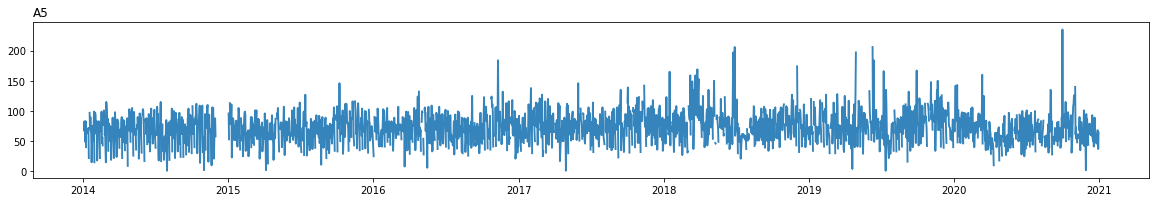

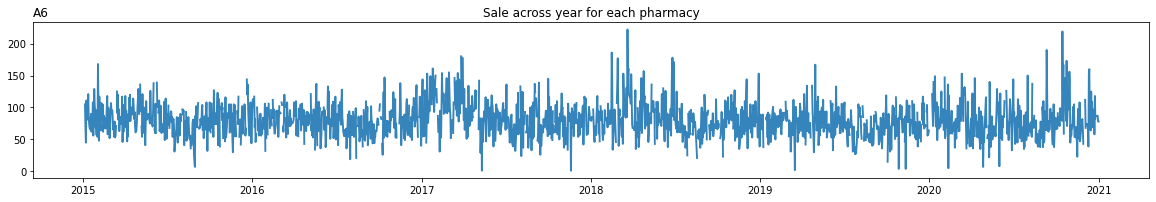

In [383]:
sale_year_pharmacy = pharmacy_sale.groupby(["SupplyDate",'Pharmacy']).sum().reset_index()
sale_year_pharmacy.sort_index(inplace=True)
sale_year_pharmacy=sale_year_pharmacy.pivot(index='SupplyDate',columns='Pharmacy', values='Sale').reset_index()
num=0
for column in sale_year_pharmacy.drop('SupplyDate', axis=1):
    num+=1
    plt.figure(figsize=(20,20))    
    # Find the right spot on the plot     
    plt.subplot(6,1, num)
    # Plot the lineplot
    plt.plot(sale_year_pharmacy['SupplyDate'], sale_year_pharmacy[column], marker='', linewidth=1.9, alpha=0.9, label=column)
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0 )
    # Same limits for every chart
    #plt.xlim(min(sale_year_pharmacy['SupplyDate']),max(sale_year_pharmacy['SupplyDate']))
    #plt.ylim(0,400)
plt.title("Sale across year for each pharmacy")
plt.show()

### <p style="color:blue;"> We will now  drop the sales of Pharmacy A4</p>


#### <p style="color:green;"> As explained above, Pharmacy A4 have unstable data, which caused the abnomality in the sale through the years. Also, the data for A4 only available until 2019, so it can be considered closed, so we can consider remove this pharmacy for modelling to avoid outliers</p>

In [384]:
pharmacy_sale = pharmacy_sale[pharmacy_sale['Pharmacy'] != 'A4'].reset_index()### Add monthly sale statistic columns

### <p style="color:blue;"> We will now add the monthly sales statistics columns </p>


#### <p style="color:green;"> Add minsale, maxsale and average sale column determining the amount of sale on average for a month for each product</p>

In [385]:
#a dataframe with product, min sale, max sale and average sale per month
prod_sale_monthly = pharmacy_sale.groupby(['ProductName', 'Units', 'Price', pd.Grouper(key='SupplyDate', freq='MS')])['Sale'].sum().to_frame().reset_index()
prod_stat_sale = prod_sale_monthly.groupby(['ProductName', 'Units', 'Price']).agg(MinSale= ('Sale','min'),MaxSale= ('Sale','max'),AvgSale= ('Sale','mean')).reset_index()

In [386]:
prod_sale_monthly

,ProductName,Units,Price,SupplyDate,Sale
0,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-03-01,1
1,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-04-01,2
2,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-06-01,2
3,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-08-01,1
4,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2015-02-01,2
...,...,...,...,...,...
140806,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2016-06-01,2
140807,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2016-10-01,1
140808,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2016-12-01,1
140809,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2017-01-01,3


In [387]:
prod_stat_sale

,ProductName,Units,Price,MinSale,MaxSale,AvgSale
0,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,1,7,1.965517
1,AACIDEXAM 5MG/ML OPL INJ FL INJ 10 X 1ML,10,19.99,4,4,4.000000
2,AACIFEMINE COMP 30 X 2 MG,30,9.30,1,22,8.409639
3,AACIFEMINE CREME VAG.TUBE+APPL. 15G,1,9.93,1,3,1.384615
4,ABASAGLAR KWIKPEN 100E/ML VOORGEV.PEN 5X3ML,5,51.11,1,2,1.500000
...,...,...,...,...,...,...
5192,ZYRTEC 10 MG FILMOMH TABL 40 X 10 MG,40,16.78,1,11,4.563636
5193,ZYRTEC DRINKB OPL 200ML 1MG/ML,1,12.29,1,5,2.301587
5194,ZYRTEC GUTT 20 ML X 10 MG/ML,1,11.01,1,3,1.450000
5195,ZYRTEC IMPEXECO COMP PELL 20 X 10MG PIP,20,11.15,1,4,1.666667


### <p style="color:blue;"> We are going to now add an expiry period column to our data </p>


Add axpiry period column determining the amount of time the product can stay on shelf

'Most medications have an expiration date between 12 to 60 months after they are manufactured.' - https://www.verywellmind.com/when-do-medications-actually-expire-380347  

We generate a column that randomize the expiry period of a product ranging from 12 to 60 months for most of products. As the goal is also to handle the products that have short expiration date, we will replace some kind of product with expiry period is only 2 and 3 months.

In [388]:
import random
expiry = pharmacy_sale.groupby(['ProductName','Units']).agg(Prod_TotalSale= ('Sale','sum')).reset_index()
expiry['Product'] = expiry['ProductName'].apply(lambda x: x.split()[0])
exp = [2,3,12,18,24,30,36,42,48,54,60]
weight = [5,5,22,44,44,44,44,33,33,33,33]
#add period for product
expiry_prod = expiry.groupby(['Product'])['Prod_TotalSale'].sum().to_frame().reset_index().drop(['Prod_TotalSale'],axis=1)
expiry_prod['ExpiryPeriod'] = random.choices(exp, weights=weight, k = len(expiry_prod)) 
expiry = expiry.merge(expiry_prod, how='inner', on=('Product'), suffixes=('', '_prod')).drop(['Product'],axis=1)
#merge to statistic dataframe
prod_sale_df = expiry.merge(prod_stat_sale, how='inner', on=(['ProductName','Units',]), suffixes=('', '_prod'))
prod_sale_df

,ProductName,Units,Prod_TotalSale,ExpiryPeriod,Price,MinSale,MaxSale,AvgSale
0,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,57,3,6.85,1,7,1.965517
1,AACIDEXAM 5MG/ML OPL INJ FL INJ 10 X 1ML,10,4,3,19.99,4,4,4.000000
2,AACIFEMINE COMP 30 X 2 MG,30,698,30,9.30,1,22,8.409639
3,AACIFEMINE CREME VAG.TUBE+APPL. 15G,1,36,30,9.93,1,3,1.384615
4,ABASAGLAR KWIKPEN 100E/ML VOORGEV.PEN 5X3ML,5,24,48,51.11,1,2,1.500000
...,...,...,...,...,...,...,...,...
5192,ZYRTEC 10 MG FILMOMH TABL 40 X 10 MG,40,251,24,16.78,1,11,4.563636
5193,ZYRTEC DRINKB OPL 200ML 1MG/ML,1,145,24,12.29,1,5,2.301587
5194,ZYRTEC GUTT 20 ML X 10 MG/ML,1,29,24,11.01,1,3,1.450000
5195,ZYRTEC IMPEXECO COMP PELL 20 X 10MG PIP,20,10,24,11.15,1,4,1.666667


### Check amount of random expiry dates

In [389]:
check = prod_sale_df.groupby(['ExpiryPeriod'])['ProductName'].count().reset_index()
check.columns = ['ExpiryPeriod', 'RandomAmt']
check['%'] = 100*check['RandomAmt']/sum(check['RandomAmt'])
check

,ExpiryPeriod,RandomAmt,%
0,2,86,1.654801
1,3,193,3.713681
2,12,235,4.521840
3,18,623,11.987685
4,24,623,11.987685
5,30,730,14.046565
6,36,694,13.353858
7,42,443,8.524149
8,48,583,11.218010
9,54,503,9.678661


In [390]:
monthly_sale_df = prod_sale_monthly.merge(prod_sale_df, how='inner', on=(['ProductName','Units', 'Price']), suffixes=('', '_prod'))
monthly_sale_df

,ProductName,Units,Price,SupplyDate,Sale,Prod_TotalSale,ExpiryPeriod,MinSale,MaxSale,AvgSale
0,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-03-01,1,57,3,1,7,1.965517
1,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-04-01,2,57,3,1,7,1.965517
2,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-06-01,2,57,3,1,7,1.965517
3,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2014-08-01,1,57,3,1,7,1.965517
4,AACIDEXAM 5MG/ML OPL INJ FL INJ 1 X 1ML,1,6.85,2015-02-01,2,57,3,1,7,1.965517
...,...,...,...,...,...,...,...,...,...,...
140806,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2016-06-01,2,9,24,1,3,1.500000
140807,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2016-10-01,1,9,24,1,3,1.500000
140808,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2016-12-01,1,9,24,1,3,1.500000
140809,ZYRTEC IMPEXECO COMP PELL 40 X 10MG PIP,40,15.27,2017-01-01,3,9,24,1,3,1.500000


# 8. Model selection
#### <p style="color:blue;">KPIs for model selection </p>
- Be able to handle time series dataset
- Be able to handle outliers
- Take into account seasonaility and stationarity
- Can handle big dataset fast 

#### <p style="color:blue;">Model selection </p>
There are 2 models being chosen for the problem regarding the KPI
1. Prophet
Why do we choose Prophet

Prophet is a procedure for forecasting time series data according to additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. Traditional model like ARIMA, SARIMA have many stringent data requirements like stationarity and equally spaced values and it is complicated when it comes to multivariate dataset. Other time forecasting model such as RNN, LSTM can be highly complex, and we choose Prophet also because they it is robust to missing data and handle outliers well.

https://facebook.github.io/prophet/

2. LSTM
Why do we chose LSTM
Fast and suitable for big dataset bla bla

# 9. Clustering
There are 5760 unique products in the dataset for which we need to forecast the sale for next month. It is totally possible to apply the chosen model to each of the product. However, as there are limitation in computer capacity, and the fact that there are some products have unstable sale, we will group products into groups depending on its sale and expiry period. By doing it, we can run the model faster and also secure the accuracy of the result. 

### <p style="color:blue;">  We cluster by sale and expiry period </p>

In [391]:
Kmean_cluster = prod_sale_df[['ExpiryPeriod','Prod_TotalSale']]

from sklearn.cluster import KMeans
def get_cluster(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    kmeans.fit(df)
    df['Cluster'] = kmeans.labels_.astype(str)
    df['Cluster'] = 'Cluster ' + df['Cluster']
    return df
Kmean_cluster_result = get_cluster(Kmean_cluster, 300)
Kmean_cluster_result

,ExpiryPeriod,Prod_TotalSale,Cluster
0,3,57,Cluster 223
1,3,4,Cluster 65
2,30,698,Cluster 27
3,30,36,Cluster 181
4,48,24,Cluster 76
...,...,...,...
5192,24,251,Cluster 32
5193,24,145,Cluster 241
5194,24,29,Cluster 204
5195,24,10,Cluster 112


In [392]:
Kmean_cluster.groupby(['Cluster']).agg({'Cluster':['count'],'Prod_TotalSale':['mean', 'min','median','max'], 'ExpiryPeriod':['mean', 'min','median','max']}).sort_values(by=('Prod_TotalSale', 'median')).head(7)

Cluster Prod_TotalSale                ExpiryPeriod               
              count           mean min median max         mean min median max
Cluster                                                                      
Cluster 277     178       1.640449   1    1.0   3    36.000000  36   36.0  36
Cluster 207     112       1.651786   1    1.0   3    48.000000  48   48.0  48
Cluster 65       95       2.357895   1    2.0   6     2.663158   2    3.0   3
Cluster 123     162       2.395062   1    2.0   5    24.000000  24   24.0  24
Cluster 125     168       2.541667   1    2.0   5    30.000000  30   30.0  30
Cluster 156     144       2.944444   1    2.0   7    60.000000  60   60.0  60
Cluster 151     123       2.536585   1    2.0   6    42.000000  42   42.0  42

### Finalize dataset for modelling

In [393]:
def make_df_cluster(cluster_df):
    Kmean_prod = pd.merge(cluster_df['Cluster'], prod_sale_df, left_index=True, right_index=True)
    df = monthly_sale_df.merge(Kmean_prod, how='inner', on=(['ProductName','Units', 'Price', 'Prod_TotalSale', 'ExpiryPeriod', 'MinSale', 'MaxSale', 'AvgSale']), suffixes=('', '_prod'))
    df = df.groupby(['SupplyDate','ProductName','Units', 'Price', 'ExpiryPeriod','Cluster', 'MinSale', 'MaxSale', 'AvgSale' ,'Prod_TotalSale'])['Sale'].sum().to_frame().reset_index()
    return df
df = make_df_cluster(Kmean_cluster_result)
df

,SupplyDate,ProductName,Units,Price,ExpiryPeriod,Cluster,MinSale,MaxSale,AvgSale,Prod_TotalSale,Sale
0,2014-01-01,AACIFEMINE COMP 30 X 2 MG,30,9.30,30,Cluster 27,1,22,8.409639,698,20
1,2014-01-01,ABILIFY 10 MG COMP 28 X 10 MG,28,124.24,48,Cluster 192,1,15,4.614286,323,8
2,2014-01-01,ABILIFY 15 MG COMP 28 X 15 MG,28,124.24,48,Cluster 5,1,14,4.750000,209,8
3,2014-01-01,ABILIFY 30 MG COMP 28 X 30 MG,28,143.79,48,Cluster 126,1,8,2.380952,150,2
4,2014-01-01,ACCOLATE COMP 56X20MG,56,26.64,24,Cluster 123,1,1,1.000000,4,1
...,...,...,...,...,...,...,...,...,...,...,...
140806,2020-12-01,ZYPREXA 5MG OMHULDE TABL 98 X 5 MG,98,181.79,36,Cluster 91,1,10,3.279412,223,6
140807,2020-12-01,ZYPREXA 10MG OMHULDE TABL 98 X 10 MG,98,354.04,36,Cluster 171,1,10,3.945946,292,5
140808,2020-12-01,ZYPREXA VELOTAB 5MG COMP ORODISP 98 X 5 MG,98,181.79,36,Cluster 149,1,13,5.808219,424,7
140809,2020-12-01,ZYPREXA VELOTAB 10MG COMP ORODISP 98 X 10 MG,98,354.04,36,Cluster 158,1,20,7.229730,535,10


# 10. Modelling: Prophet model

## 10.1 Modeling Prophet with cluster

### <p style="color:blue;">  We will do the modelling using the prophet model based on the clusters we generated </p>

In [394]:
def make_prophet_ds(input_df):
    prophet_df = input_df.groupby(['SupplyDate', 'Cluster'])['Sale'].mean().to_frame().reset_index()
#I filter first Clusters with less than 3 records to avoid errors as prophet only works for 2+ records by group
    prophet_df = prophet_df.rename(columns={'SupplyDate': 'ds', 'Sale': 'y', 'Cluster': 'Cluster'}).groupby('Cluster').filter(lambda x: len(x) > 2)
    return prophet_df

prophet_df = make_prophet_ds(df)
prophet_df

,ds,Cluster,y
0,2014-01-01,Cluster 0,1.214286
1,2014-01-01,Cluster 1,41.000000
2,2014-01-01,Cluster 10,50.000000
3,2014-01-01,Cluster 100,9.000000
4,2014-01-01,Cluster 101,3.750000
...,...,...,...
24800,2020-12-01,Cluster 95,1.400000
24801,2020-12-01,Cluster 96,1.750000
24802,2020-12-01,Cluster 97,1.000000
24803,2020-12-01,Cluster 98,1.000000


In [395]:
def get_prediction(df):
    #prediction = {}
    list_cluster = df.Cluster.unique()
    final = pd.DataFrame()
    for cluster in list_cluster:
        cluster_df = df.loc[df['Cluster'] == cluster]
        # set the uncertainty interval to 95% (the Prophet default is 80%)
        my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0)
        my_model.fit(cluster_df)
        #future_dates = my_model.make_future_dataframe(periods=2, freq='MS', include_history = True)
        # define the period for which we want a prediction
        future = list()
        for i in range(1, 13):
            date = '2020-%02d' % i
            future.append([date])
        future = pd.DataFrame(future)
        future.columns = ['ds']
        future['ds']= pd.to_datetime(future['ds'])
        forecast = my_model.predict(future)
        forecast['Cluster'] = cluster
        final = pd.concat([final, forecast], ignore_index=True)
    return final
#my_model.plot(forecast)

result = get_prediction(prophet_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.


## 10.2 Validation

### Manual validation

### <p style="color:blue;">  We now valid our results </p>

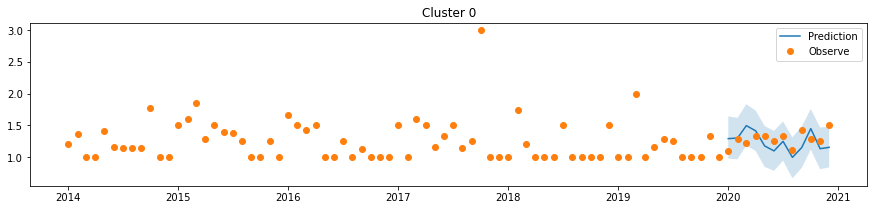

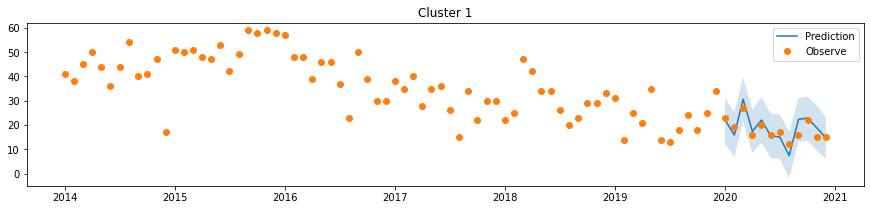

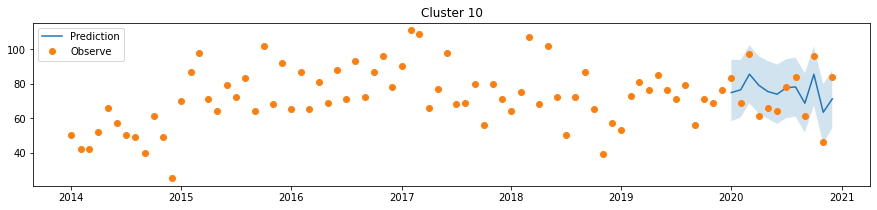

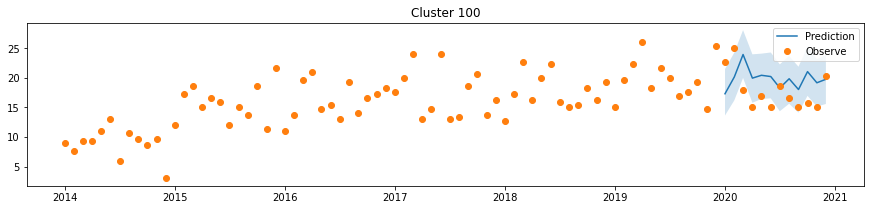

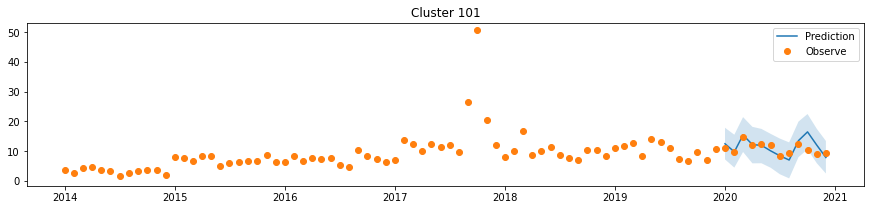

In [396]:
def valid_graph(df, result_df, amt_cluster_to_visualize):
    list_cluster = df.Cluster.unique()
    list_cluster = list_cluster[:amt_cluster_to_visualize]
    for cluster in list_cluster:
        cluster_sale = df[df['Cluster'] == cluster ]
        cluster_pred = result[result['Cluster'] == cluster ]
        fig, ax = plt.subplots(figsize=(15, 3))
        ax.plot(cluster_pred['ds'], cluster_pred['yhat'],'-',label = 'Prediction')
        ax.plot(cluster_sale['ds'], cluster_sale['y'],'o', label = 'Observe')
        ax.fill_between(cluster_pred['ds'], cluster_pred['yhat_lower'], cluster_pred['yhat_upper'], alpha=0.2)
        ax.legend()
        ax.set_title(cluster)

valid_graph(prophet_df,result,5)

### <p style="color:blue;"> RMSE </p>
Root mean squared error (RMSE): RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It is the square root of the average of squared differences between prediction and actual observation, where larger errors are weighted much more heavily than smaller errors.

#### <p style="color:green;"> This is saying that the forecasted values different on average compared to what the real values tend to be. In this case, the RMSE score is saying that in average the predicted sale is on average 42 units higher or lower than actual sale. 

In [397]:
import math 
def get_rmse(df, result_df):
    compare_result = result_df.merge(df, on=['ds','Cluster'], how='inner')
    sale_predict = compare_result['yhat']
    sale_observe = compare_result['y']
    # Compute the mean square error
    mse = math.sqrt(((sale_predict - sale_observe) ** 2).mean())
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

rsme = get_rmse(prophet_df,result)

The Root Mean Squared Error of our forecasts is 6.11


### <p style="color:blue;"> Next, we check the RMSE for each cluster</p>

In [398]:
def get_rmse_df(df, result_df):
    num=0
    rmse = []
    list_cluster = df.Cluster.unique()
    for cluster in list_cluster:
        num+=1
        compare_result = result_df.merge(df, on=['ds','Cluster'], how='inner')
        sale_predict =compare_result['yhat'][compare_result['Cluster']==cluster]
        sale_observe =compare_result['y'][compare_result['Cluster']==cluster]
        mse = math.sqrt(((sale_predict - sale_observe) ** 2).mean())
    #print('The Root Mean Squared Error of our forecasts for',cluster, 'is {}'.format(round(mse, 2)))
        rmse.append(
            {
                'Cluster': cluster,
                'RMSE': mse
            }
        )
    return pd.DataFrame(rmse)
rmse_df = get_rmse_df(prophet_df,result)

rmse_df

,Cluster,RMSE
0,Cluster 0,0.187981
1,Cluster 1,3.017548
2,Cluster 10,10.945783
3,Cluster 100,4.256940
4,Cluster 101,2.278199
...,...,...
295,Cluster 36,6.769796
296,Cluster 6,2.741538
297,Cluster 94,9.453191
298,Cluster 42,22.565359


### <p style="color:blue;"> MAE </p>
Mean Absolute Error (MAE): MAE measures the average magnitude of the errors in a set of predictions, without considering their direction (it could be off in positive sense or negative sense). It is the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

#### <p style="color:green;"> The calculation of RMSE involves squaring the difference numbers, this means that this metric can be signified by large differences compared to MAE.So when you are comparing two models (or three or more) and are interested in improving the larger differences, then RMSE would give  a more reliable insight. </p>

In [399]:
compare_result = result.merge(prophet_df, on=['ds','Cluster'], how='inner')
sale_predict = compare_result['yhat']
sale_observe = compare_result['y']
# Compute the mean square error
mae_ab =abs((sale_predict - sale_observe).mean())
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae_ab, 2)))

The Mean Absolute Error of our forecasts is 0.66


## 10.3 Optimization

### <p style="color:blue;"> Optimize the model by increase amount of cluster and comparing RSME result </p>

In [400]:

#Kmean_prod = pd.merge(Kmean_cluster_opt['Cluster'], prod_sale_df, left_index=True, right_index=True)

In [401]:
Kmean_cluster_opt = prod_sale_df[['ExpiryPeriod','Prod_TotalSale']]

def get_rsme_opt(n_clusters):
    Kmean_cluster_opt = prod_sale_df[['ExpiryPeriod','Prod_TotalSale']]
    Kmean_cluster_result_opt= get_cluster(Kmean_cluster_opt, n_clusters)
    df_opt = make_df_cluster(Kmean_cluster_result_opt)
    prophet_df_opt = make_prophet_ds(df_opt)
    result_opt = get_prediction(prophet_df_opt)
    rsme_opt = get_rmse(prophet_df_opt,result_opt)
    #rsme_df_opt = get_rmse_df(prophet_df_opt,result_opt)
    return rsme_opt

RSME with 60 of clusters:

get_rsme_opt(60)


RSME with 100 of clusters:

get_rsme_opt(100)

# 11. Modelling: LSTM model

## 11.1 Modeling LSTM with cluster

### <p style="color:blue;"> Make supervised learning dataframe that can be suitable for LSTM model: </p>

In [402]:
#Change date to month block numbera consecutive month number, used for convenience.
#Ex:January 2013 is 0, February 2013 is 1,..., October 2015 is 33
add_monthNr = df.groupby(['SupplyDate'])['Sale'].sum().to_frame()
add_monthNr= add_monthNr.reset_index().reset_index()
add_monthNr = add_monthNr.rename(columns={'index':'month_block'}).drop('Sale',axis =1)

sale = df.groupby(['SupplyDate','Cluster'])['Sale'].sum().to_frame().reset_index()
#sale['Cluster']= sale.Cluster.str.extract('(\d+)')
sale = sale.merge(add_monthNr, how='inner', on=('SupplyDate'), suffixes=('_y', '')).drop('SupplyDate',axis=1)
sale= sale.pivot_table(index= 'Cluster', values = 'Sale',columns = 'month_block',fill_value = 0,aggfunc='sum')
sale.tail(10)

month_block,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
Cluster,,,,,,,,,,,,,,,,,,,,,
Cluster 90,45,36,41,34,37,32,30,36,30,33,...,31,24,24,32,16,23,23,33,22,29
Cluster 91,8,10,11,9,13,16,3,17,14,12,...,21,11,32,16,43,14,27,32,15,17
Cluster 92,21,17,27,14,26,20,16,13,19,29,...,56,52,34,51,39,33,58,54,53,43
Cluster 93,51,35,42,40,48,49,24,54,27,48,...,38,21,32,36,25,32,36,30,29,36
Cluster 94,0,0,0,0,0,0,0,0,0,0,...,19,11,11,12,12,11,15,16,4,15
Cluster 95,18,11,17,8,11,11,8,10,15,9,...,13,16,10,11,11,6,19,15,13,7
Cluster 96,23,21,35,48,45,30,22,35,35,33,...,12,12,17,13,8,12,9,11,27,14
Cluster 97,26,16,28,17,29,16,20,11,20,22,...,8,8,16,15,17,12,15,21,12,5
Cluster 98,15,8,21,18,18,16,10,17,15,14,...,7,10,7,6,10,9,14,12,8,8


### <p style="color:blue;"> Now we will split train, test set and scale dataset </p>

In [403]:
train_set, test_set = sale[:-20].values, sale[-20:].values

### <p style="color:blue;"> As the sale for clusters are highly ranging, some cluster have more than 600 sales and some only 20. So we need to scale it before modelling.</p>

In [404]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

train_set = scaler.transform(train_set)
test_set = scaler.transform(test_set)

In [405]:
X_train, y_train = train_set[:,:-1], train_set[:, -1:]
X_test, y_test = test_set[:,:-1], test_set[:, -1:]

### <p style="color:blue;">Reshape train, test data so it can be suitable for LSTM modelling </p>




In [406]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train= X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test= X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [407]:
y_train = y_train.reshape(len(y_train))

In [408]:
y_train

array([-0.80851064, -0.84042553, -0.10638298, -0.35106383, -0.5       ,
       -0.55319149, -0.5212766 , -0.45744681, -0.70212766, -0.84042553,
       -0.43617021, -0.57446809, -0.89361702, -0.68085106, -0.76595745,
       -0.56382979, -0.84042553, -0.73404255, -0.91489362, -0.82978723,
       -0.4893617 , -0.75531915, -0.80851064, -0.59574468, -0.38297872,
       -0.38297872, -0.95744681, -0.04255319, -0.90425532, -0.89361702,
       -0.94680851, -0.69148936, -0.95744681, -0.41489362, -0.58510638,
       -0.60638298, -0.84042553, -0.77659574, -0.89361702, -0.72340426,
       -0.35106383, -0.5212766 , -0.22340426, -0.89361702, -0.79787234,
        1.        , -0.11702128, -0.82978723, -0.88297872, -0.84042553,
       -0.06382979, -0.80851064, -0.24468085, -0.57446809, -0.74468085,
       -0.65957447, -0.42553191, -0.0106383 , -0.59574468, -0.92553191,
       -0.92553191, -0.06382979, -0.60638298, -0.96808511, -0.82978723,
       -0.63829787, -0.18085106, -0.69148936, -0.93617021, -0.56

In [409]:
y_train.shape

(280,)

In [410]:
X_test.shape

(20, 83, 1)

In [411]:
X_train.shape

(280, 83, 1)

#### Modelling
### <p style="color:blue;">Train model </p>

In [412]:
n_steps = 83
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [413]:
history = model.fit(X_train, y_train, epochs=200, verbose=0)

### <p style="color:blue;"> Forecast test set </p>


In [414]:
yhat = model.predict(X_test, verbose=0)
yhat

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

### <p style="color:blue;"> Reshape result </p>

In [415]:
#reshape 
yhat = yhat.reshape(yhat.shape[0],1, yhat.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1,  X_test.shape[1])
yhat

array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]], dtype=float32)

In [416]:
pred_test_set = []
for index in range(0,len(yhat)):   
    #print(np.concatenate([yhat[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([X_test[index],yhat[index]],axis=1)) 

### <p style="color:blue;"> we will now inverse from scaling </p>

In [417]:
#reshape pred_test_set to make the shape equal to test set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [418]:
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
pred_test_set_inverted

array([[24., 18., 11., ..., 25., 23., nan],
       [17., 24., 21., ..., 41., 29., nan],
       [20., 18., 21., ..., 16., 11., nan],
       ...,
       [26., 16., 28., ..., 21., 12., nan],
       [15.,  8., 21., ..., 12.,  8., nan],
       [53., 43., 36., ..., 66., 43., nan]])

## 11.2 Validation

### Actual and predict result

### <p style="color:blue;"> Below are the actual values compared to those that are being predicted </p>


In [419]:
sale = sale.reset_index()
result_list = []
act_sales = list(sale[83][-20:])
sales_cluster = list(sale[-20:].Cluster)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['Cluster'] = sales_cluster[index]
    result_dict['actual_value'] = act_sales[index]
    result_dict['pred_value'] = int(pred_test_set_inverted[index][-1])
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
df_result = df_result[df_result['pred_value'] > 0]
df_result

ValueError: cannot convert float NaN to integer

In [ ]:
df_result.plot(kind='bar', x= 'Cluster' , title='LSTM', figsize=(10, 7))


### RSME

In [ ]:
import math

val_predict = df_result['pred_value']
val_actual = df_result['actual_value']
# Compute the mean square error
lstm_rmse = math.sqrt(((val_predict - val_actual) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(lstm_rmse, 2)))

The RSME is pretty good as compare to the amount of train set and test set. In this case, the RSME can improve by incresing the amount of cluster 

## 11.3 Optimization

In [ ]:
df_his1 = pd.DataFrame(history.history)
plt.figure(figsize = (10 , 10))
sns.lineplot(x= df_his1.index + 1, y = df_his1['loss'], color='r', label="LSTM loss")

The loss is extremly high with epoch lower 25 but is acceptable with other value. So we can keep the epoch in 200 or lower it to the value ranging from 50 to 200.

# 12. Model comparision

In this notebook, we already applied Prophet model and LSTM model. Both model works well and can give good prediction. However, each of the model has its pros and cons.

Prophet works great with time-series, it give good prediction and handle outliers pretty well, the RSME score is in acceptable range. The cons of Prophet is that it takes long time to run the model. The bigger the dataset, the longer times it takes to train and predict. Also, it require computer with strong performance to perform fast and without shutting down in the mean time.

LTSM, in the other hand, works great with big dataset and also give good result and RSME score although it is the complicated model and it takes time to apply it properly and get correct result.

When comparing two model using RSME metrics, Prophet seems to outperform LSTM as it give lower RSME score. Which means, the difference between predicted value and the actual value is not so high with Prophet model, as compared to LSTM.

# 13.Final Result Explanation

### <p style="color:blue;"> Handling products with short life period </p>


We can decide on the stocking amount for next month sale by taking into acount expiry period, min/max/average month sale, RSME and predicted value. Lets take the result from Prophet model to calculate the stock, especially for products with short life circle date.

### <p style="color:blue;"> First, run the dataframe with date, product, predict value, actual value and other variables: </p>


In [ ]:
compare_result = result.merge(prophet_df, on=['ds','Cluster'], how='inner')
compare = compare_result[['ds','Cluster','yhat','y']].rename(columns={'ds': 'SupplyDate'})
compare = compare.merge(df, on=['SupplyDate','Cluster'], how='inner').rename(columns={'yhat': 'PredictedSale'}).drop('y',axis=1)
compare['PredictedSale'] = compare['PredictedSale'].apply(np.ceil)
compare['AvgSale'] = round(compare['AvgSale'],0)

For products that have expiry date from 2 to 3 months, we will reduce the possibility of overstocking (which can lead to money loss for the company) by only stock the amount that smaller than maximum sale record. We will also calculate possible loss :

- for product with short life, possible loss calculate possible loss if the predicted sale higher than average sale record.
- for product with average life period, possible loss calculate possible loss if the predicted sale higher than maximum sale record.

In [ ]:
conditions = [
    (compare['ExpiryPeriod'] < 4) & (compare['PredictedSale'] > compare['AvgSale']),
    (compare['ExpiryPeriod'] > 3) & (compare['PredictedSale'] > compare['MaxSale'])
    ]

# create a list of the values we want to assign for each condition
values = [round((compare['PredictedSale']-compare['AvgSale'])*compare['Price'],2), round((compare['PredictedSale']-compare['MaxSale'])*compare['Price'],2)]

# create a new column and use np.select to assign values to it using our lists as arguments
compare['PossibleLoss-overstock'] = np.select(conditions, values)

# display updated DataFrame
#compare[compare['ExpiryPeriod'] < 3][compare['Prod_TotalSale'] > 30].head(30)


In [ ]:
fn_result = compare.merge(rmse_df, on = 'Cluster', how='left')
fn_result = fn_result[['SupplyDate', 'Cluster', 'ProductName', 'Price', 'ExpiryPeriod','Prod_TotalSale',  'AvgSale', 'MinSale', 'MaxSale', 'PredictedSale', 'RMSE', 'PossibleLoss-overstock', 'Sale']]
#result[result['Sale'] >10][result['PossibleLoss-overstock'] >0].sample(10)
fn_result[fn_result['ExpiryPeriod'] < 4]

With the possible loss calculation, together with expiry period and the predicted sale, the company can decide on how many product to restock depends on the amount of possible loss that they can accept. For example, with the product above, the predicted sale is 3, the maximum amount that they ever sold is 2, so if they stock 3 as predicted, the possible loss if they cannot sell all of it within 2 months for this product is 13,28 euro.